In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['87+67  ', '4+205  ', '7+5    ', '551+0  ', '223+326'] ['154 ', '209 ', '12  ', '551 ', '549 ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False  True
   False]
  [False False False  True False False False False False False False
   False]
  [False False  True False False False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False False False False False False False  True
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False  True False False False False False False
   False]
  [False False False False  True False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False False False Fal

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 9s 493us/step - loss: 2.0258 - acc: 0.2868 - val_loss: 1.8685 - val_acc: 0.3244
Epoch 2/200
18000/18000 [==============================] - 4s 204us/step - loss: 1.8568 - acc: 0.3299 - val_loss: 1.8325 - val_acc: 0.3310
Epoch 3/200
18000/18000 [==============================] - 4s 197us/step - loss: 1.8182 - acc: 0.3306 - val_loss: 1.8067 - val_acc: 0.3326
Epoch 4/200
18000/18000 [==============================] - 4s 200us/step - loss: 1.7871 - acc: 0.3373 - val_loss: 1.7724 - val_acc: 0.3438
Epoch 5/200
18000/18000 [==============================] - 3s 187us/step - loss: 1.7319 - acc: 0.3565 - val_loss: 1.7229 - val_acc: 0.3629
Epoch 6/200
18000/18000 [==============================] - 3s 180us/step - loss: 1.6624 - acc: 0.3776 - val_loss: 1.6474 - val_acc: 0.3754
Epoch 7/200
18000/18000 [==============================] - 3s 180us/s

18000/18000 [==============================] - 4s 200us/step - loss: 0.0523 - acc: 0.9931 - val_loss: 0.1055 - val_acc: 0.9692
Epoch 58/200
18000/18000 [==============================] - 3s 186us/step - loss: 0.0803 - acc: 0.9802 - val_loss: 0.1005 - val_acc: 0.9715
Epoch 59/200
18000/18000 [==============================] - 3s 192us/step - loss: 0.0627 - acc: 0.9873 - val_loss: 0.0850 - val_acc: 0.9757
Epoch 60/200
18000/18000 [==============================] - 3s 192us/step - loss: 0.0512 - acc: 0.9913 - val_loss: 0.0788 - val_acc: 0.9781
Epoch 61/200
18000/18000 [==============================] - 4s 199us/step - loss: 0.0395 - acc: 0.9957 - val_loss: 0.0685 - val_acc: 0.9806
Epoch 62/200
18000/18000 [==============================] - 3s 184us/step - loss: 0.0423 - acc: 0.9935 - val_loss: 0.0968 - val_acc: 0.9695
Epoch 63/200
18000/18000 [==============================] - 3s 183us/step - loss: 0.0632 - acc: 0.9855 - val_loss: 0.2364 - val_acc: 0.9266
Epoch 64/200
18000/18000 [=======

Epoch 115/200
18000/18000 [==============================] - 3s 180us/step - loss: 0.0043 - acc: 0.9998 - val_loss: 0.0291 - val_acc: 0.9900
Epoch 116/200
18000/18000 [==============================] - 3s 180us/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0279 - val_acc: 0.9909
Epoch 117/200
18000/18000 [==============================] - 3s 181us/step - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0336 - val_acc: 0.9890
Epoch 118/200
18000/18000 [==============================] - 3s 187us/step - loss: 0.0499 - acc: 0.9859 - val_loss: 0.5372 - val_acc: 0.8568
Epoch 119/200
18000/18000 [==============================] - 3s 180us/step - loss: 0.0878 - acc: 0.9716 - val_loss: 0.0464 - val_acc: 0.9840
Epoch 120/200
18000/18000 [==============================] - 3s 188us/step - loss: 0.0088 - acc: 0.9991 - val_loss: 0.0278 - val_acc: 0.9904
Epoch 121/200
18000/18000 [==============================] - 3s 190us/step - loss: 0.0048 - acc: 0.9998 - val_loss: 0.0269 - val_acc: 0.9916
Epoch 122/200

18000/18000 [==============================] - 3s 182us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9938
Epoch 174/200
18000/18000 [==============================] - 3s 183us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 0.9945
Epoch 175/200
18000/18000 [==============================] - 3s 187us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9935
Epoch 176/200
18000/18000 [==============================] - 3s 181us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0188 - val_acc: 0.9939
Epoch 177/200
18000/18000 [==============================] - 3s 181us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9937
Epoch 178/200
18000/18000 [==============================] - 3s 181us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 179/200
18000/18000 [==============================] - 3s 185us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9934
Epoch 180/200
18000/18000 [

Text(0.5,1,'3 digits add')

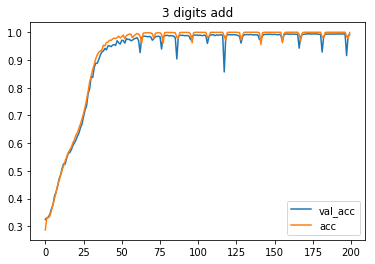

In [21]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('3 digits add')

# Testing

In [20]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000:
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)

MSG : Prediction
30  Q 124+326 T 450  ☒ 440 
63  Q 54+196  T 250  ☒ 240 
66  Q 444+961 T 1405 ☒ 1305
67  Q 272+28  T 300  ☒ 200 
72  Q 149+0   T 149  ☒ 140 
99  Q 855+45  T 900  ☒ 800 
126  Q 324+77  T 401  ☒ 301 
145  Q 581+9   T 590  ☒ 580 
147  Q 0+147   T 147  ☒ 137 
157  Q 28+62   T 90   ☒ 80  
165  Q 593+6   T 599  ☒ 699 
168  Q 403+491 T 894  ☒ 994 
197  Q 0+6     T 6    ☒ 3   
200  Q 722+284 T 1006 ☒ 9006
246  Q 154+116 T 270  ☒ 260 
302  Q 307+172 T 479  ☒ 489 
418  Q 843+186 T 1029 ☒ 1039
445  Q 444+961 T 1405 ☒ 1305
472  Q 278+22  T 300  ☒ 390 
482  Q 69+631  T 700  ☒ 600 
524  Q 599+601 T 1200 ☒ 1290
535  Q 35+75   T 110  ☒ 100 
604  Q 898+694 T 1592 ☒ 1582
608  Q 660+745 T 1405 ☒ 1305
617  Q 181+821 T 1002 ☒ 902 
661  Q 32+38   T 70   ☒ 60  
699  Q 31+80   T 111  ☒ 112 
731  Q 416+283 T 699  ☒ 709 
734  Q 17+63   T 80   ☒ 70  
739  Q 19+0    T 19   ☒ 29  
745  Q 541+59  T 600  ☒ 500 
802  Q 207+202 T 409  ☒ 419 
886  Q 22+778  T 800  ☒ 700 
917  Q 546+55  T 601  ☒ 501 
922

accu: 0.96505
